In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from tqdm import tqdm


# In[106]:


dt_coeff = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/Defaultcoefficients.csv', sep = ',',index_col = 0)
    

# In[107]:


dt_hpichange_coeff = dt_coeff.iloc[13][0]
dt_diffhpivolatility_coeff = dt_coeff.iloc[14][0]
dt_time_coeff = dt_coeff.iloc[15:55]
dt_coeff = dt_coeff.iloc[0:13]['Estimate']


# In[108]:


dt_hpichange_coeff


# In[109]:


dt_coeff


# In[110]:


pp_coeff = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/Prepaymentcoefficients.csv', sep = ',',index_col = 0)


# In[30]:


pp_coeff


# In[111]:


pp_changeinhpi_coeff = pp_coeff.iloc[4][0]


# In[62]:


pp_changeinhpi_coeff


# In[112]:


pp_refi_coeff = pp_coeff.iloc[5][0]


# In[113]:


pp_refi_coeff


# In[114]:


pp_time_coeff = pp_coeff.iloc[13:53]


# In[64]:


pp_time_coeff


# In[115]:


pp_coeff = pp_coeff.iloc[0:4].append(pp_coeff.iloc[6:13])['Estimate']
#pp_coeff = pp_coeff.iloc[0:6].append(pp_coeff.iloc[8:19])['Estimate']


# In[61]:


pp_coeff


# In[116]:


#get h0 for dt and pp
h0_dt = []
h0_pp = []
for i in dt_time_coeff.iloc[:,0]:
    h0_dt.append(math.exp(i))
for i in pp_time_coeff.iloc[:,0]:
    h0_pp.append(math.exp(i))


# In[66]:


h0_dt


# In[67]:


h0_pp


# In[117]:



def cheng(x,y):
    temp = 0
    for i in range(len(x)):
        temp += x[i]*y[x.index[i]]
    return temp


# In[134]:



#get data
data = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/CAS2018DealRefined.csv', sep = ',',index_col = 0)
#data = data[(data['fico']<999) & (data['ltv']<998) & (data['dti']<998)]


# In[135]:


data = data[(data['fico']<999) & (data['ltv']<998) & (data['dti']<998)]


# In[120]:


note_rate = data['New_Int_rt'].tolist()
state = data['st'].tolist()


# In[121]:

mor_path = pd.read_excel('C:/Users/DELL/Desktop/CASSimulation/s_m_10_ADJ.xlsx')
#hpa_path = pd.read_excel('inte_h_sim.xlsx')


# In[122]:


hpa_path = pd.read_excel('C:/Users/DELL/Desktop/CASSimulation/HPA_ADJ.xlsx')



# In[123]:


baselines = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/baselines.csv', sep = ',')


# In[124]:


state_adj = pd.read_table('C:/Users/DELL/Desktop/CASSimulation/hpa_state_adj_cvs.csv', sep = ',',index_col = 0)

# Be patient this loop takes 7 hours time to run on I5 processor
# In[159]:
n = 9999 #len(data)# Run n loans
start = 0# Start loan
#The loop
default_rate = [0]*n
pp_rate = [0]*n

probability_allloans=0
for j in tqdm(range(n)):# Loan j
    cum_probability_defaults_allquarter=0
    Dflt_Xb_unchanged = cheng(dt_coeff,data.iloc[j + start])
    PP_Xb_unchanged = cheng(pp_coeff,data.iloc[j + start])
    default_rate[j] = [0]*500
    pp_rate[j] = [0]*500
    state_adj_temp = state_adj[state[j+start]].tolist()
    
    for k in range(500):# Path k
        Dflt_Xb = [0]*41
        PP_Xb = [0]*41
        Dflt_Hazard = [0]*41
        PP_Hazard = [0]*41
        Surv_Prob = [1]*41
        Est_Period_Dflts = [0]*41
        Est_Period_PPs = [0]*41
        hpa_path_temp = hpa_path.iloc[:,k].tolist()
        mor_path_temp = mor_path.iloc[:,k].tolist()
        sum_dflt=0
        sum_PP=0
        default_quarter_rate=[]
        default_quarter_rate_takeout=[]
        PP_quarter_rate=[]
        
        for i in range(1,41):# Quarter i
            hpa_temp = (hpa_path_temp[(i-1)]) * (1 + state_adj_temp[(i-1)])
            Dflt_Xb[i] = Dflt_Xb_unchanged +  hpa_temp * dt_hpichange_coeff + min(hpa_temp,0) * (dt_hpichange_coeff)
            PP_Xb[i] = PP_Xb_unchanged + hpa_temp * pp_changeinhpi_coeff +            (note_rate[j + start] - mor_path_temp[(i-1)] + 1) * pp_refi_coeff
            Dflt_Hazard[i] = 1 - math.exp(-h0_dt[i-1] * math.exp(Dflt_Xb[i]))
            PP_Hazard[i] = 1 - math.exp(-h0_pp[i-1] * math.exp(PP_Xb[i]))
            Surv_Prob[i] = Surv_Prob[(i-1)] * (1 - Dflt_Hazard[i] - PP_Hazard[i])
            Est_Period_Dflts[i] = Dflt_Hazard[i] * Surv_Prob[(i-1)]
            Est_Period_PPs[i] = PP_Hazard[i] * Surv_Prob[(i-1)]
            sum_dflt=sum_dflt+Est_Period_Dflts[i]
            sum_PP = sum_PP+Est_Period_PPs[i]
            default_quarter_rate.append(sum_dflt)
            PP_quarter_rate.append(sum_PP)
            
            if(i==40):
                default_quarter_rate_takeout=default_quarter_rate
                
        default_rate[j][k] =default_quarter_rate_takeout
        #print(default_quarter_rate_takeout)     
        #pp_rate[j][k] = PP_quarter_rate[k]
            
            

result_dt = pd.DataFrame(default_rate)

100%|██████████| 9999/9999 [2:05:10<00:00,  3.62it/s]     


In [2]:
result_dt

NameError: name 'result_dt' is not defined

In [2]:
import matplotlib.pyplot as plt
data1=pd.read_table('C:/Users/DELL/Desktop/CASSimulation/allcasdataincsvformat10000loans.csv', sep = '|',index_col = 0)


In [4]:
data1

,LOAN IDENTIFIER,MONTHLY REPORTING PERIOD,ORIGINATION CHANNEL,SELLER NAME,SERVICER NAME,MASTER SERVICER,ORIGINAL INTEREST RATE,CURRENT INTEREST RATE,ORIGINAL UPB,UPB AT ISSUANCE,...,INITIAL INTEREST RATE CAP,PERIODIC INTEREST RATE CAP,LIFETIME INTEREST RATE CAP,MARGIN,BALLOON INDICATOR,PLAN NUMBER,FORBEARANCE INDICATOR,HIGH LOAN-TO-VALUE(HLTV) REFINANCE OPTION INDICATOR,DEAL NAME,",,"
REFERENCE POOL ID,,,,,,,,,,,,,,,,,,,,,
5083,91182090,72018,R,Other,Other,FANNIE MAE,4.625,4.625,215000.0,214000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2018C06G1,,",NaN
5083,91182091,72018,C,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",FANNIE MAE,4.875,4.875,196000.0,195000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018C06G1,NaN
5083,91182092,72018,R,Other,Other,FANNIE MAE,4.250,4.250,390000.0,387000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2018C06G1,,",NaN
5083,91182093,72018,R,Quicken Loans Inc.,Quicken Loans Inc.,FANNIE MAE,4.990,4.990,200000.0,199000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2018C06G1,,",NaN
5083,91182094,72018,C,"NationStar Mortgage, LLC","NationStar Mortgage, LLC",FANNIE MAE,4.250,4.250,384000.0,382000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018C06G1,NaN
5083,91182095,72018,R,"JPMorgan Chase Bank, National Association","JP Morgan Chase Bank, NA",FANNIE MAE,3.750,3.750,168000.0,164000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018C06G1,NaN
5083,91182096,72018,R,Fairway Independent Mortgage Corporation,Arvest Central Mortgage Company,FANNIE MAE,5.125,5.125,107000.0,106000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2018C06G1,,",NaN
5083,91182097,72018,R,"JPMorgan Chase Bank, National Association","JP Morgan Chase Bank, NA",FANNIE MAE,4.125,4.125,217000.0,215000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018C06G1,NaN
5083,91182098,72018,R,"Wells Fargo Bank, N.A.","Wells Fargo Bank, N.A.",FANNIE MAE,4.000,4.000,308000.0,306000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018C06G1,NaN


In [3]:
#Projecting the UPB's for each loan for each of the 40 quarters
Monthly_Balance_Cas =[]
sumUPB=0
for index,row in data1.iterrows():
    sumUPB=sumUPB+ row['ORIGINAL UPB']
    Loan_Amount = row['ORIGINAL UPB']
    Interest_rate = row['CURRENT INTEREST RATE']
    
    Loan_Term = 360
    R = 1+(Interest_rate)/(12*100)
    X = Loan_Amount * (R**Loan_Term)*(1-R)/(1-R**Loan_Term)

    Monthly_Interest = []
    Monthly_Balance = []

    for i in range(1, 123):
        Interest = Loan_Amount*(R-1)
        Loan_Amount = (Loan_Amount - (X-Interest))
        if (i%3 ==0) and (i != 1):
            Monthly_Interest.append(Interest)
            Monthly_Balance.append(Loan_Amount)
            

    Monthly_Balance_Cas.append(Monthly_Balance)



In [4]:
Monthly_Balance_Cas=pd.DataFrame(Monthly_Balance_Cas)

In [5]:
Monthly_Balance_Cas=Monthly_Balance_Cas.mul(0.25)

In [9]:
Monthly_Balance_Cas

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,53541.633385,53330.848234,53117.616474,52901.909707,52683.699206,52462.955909,52239.650418,52013.752993,51785.233549,51554.061652,...,46028.901905,45730.915570,45429.470472,45124.526464,44816.042934,44503.978798,44188.292496,43868.941985,43545.884733,43219.077718
1,48818.516125,48634.811418,48448.858702,48260.630468,48070.098871,47877.235723,47682.012493,47484.400302,47284.369914,47081.891739,...,42207.960589,41943.361993,41675.525483,41404.411437,41129.979747,40852.189815,40571.000545,40286.370340,39998.257093,39706.618182
2,97095.584389,96686.856626,96273.770732,95856.280238,95434.338178,95007.897087,94576.908994,94141.325414,93701.097349,93256.175276,...,82734.932520,82173.081799,81605.240246,81031.343984,80451.328452,79865.128404,79272.677895,78673.910279,78068.758199,77457.153579
3,49818.682158,49635.092957,49449.203944,49260.986309,49070.410882,48877.448126,48682.068136,48484.240631,48283.934952,48081.120054,...,43183.050978,42916.337577,42646.283070,42372.845605,42095.982803,41815.651756,41531.809017,41244.410594,40953.411947,40658.767975
4,95601.806168,95199.366524,94792.635798,94381.568234,93966.117590,93546.237132,93121.879625,92692.997331,92259.542005,91821.464887,...,81462.087405,80908.880541,80349.775012,79784.707923,79213.615707,78636.434121,78053.098235,77463.542429,76867.700380,76265.505062
5,41809.630688,41617.471081,41423.504341,41227.713475,41030.081328,40830.590583,40629.223762,40425.963222,40220.791152,40013.689578,...,35185.138103,34930.679599,34673.828083,34414.561052,34152.855788,33888.689363,33622.038630,33352.880227,33081.190569,32806.945853
6,26655.380625,26559.543753,26462.473721,26364.154659,26264.570496,26163.704955,26061.541546,25958.063571,25853.254113,25747.096041,...,23173.436639,23032.796557,22890.346817,22746.064134,22599.924923,22451.905295,22301.981054,22150.127693,21996.320390,21840.534003
7,54019.896514,53787.411920,53552.521577,53315.200592,53075.423811,52833.165823,52588.400951,52341.103256,52091.246526,51838.804281,...,45890.329241,45573.719967,45253.834423,44930.638707,44604.098566,44274.179390,43940.846214,43604.063709,43263.796183,42920.007572
8,76666.060004,76328.769464,75988.094763,75644.001946,75296.456719,74945.424442,74590.870128,74232.758440,73871.053684,73505.719810,...,64927.533890,64472.466370,64012.832989,63548.587936,63079.684940,62606.077267,62127.717713,61644.558600,61156.551773,60663.648593
9,52282.237748,52062.153568,51839.722702,51614.920128,51387.720557,51158.098431,50926.027920,50691.482915,50454.437034,50214.863610,...,44549.579049,44247.044046,43941.283210,43632.262145,43319.946090,43004.299910,42685.288097,42362.874766,42037.023646,41707.698081


In [6]:
#Summing the losses across each path for each quarter
losses_allquarters=[]
losses_plot=[]
for k in range(1,501):# Path k
    t = 0
    for i in range(1,41):# Quarter i
        t=.25*i
        losses_quarter=[0]
        for j in range(1,10000):
            losses_quarter=losses_quarter+Monthly_Balance_Cas[i-1][j-1]*result_dt[k-1][j-1][i-1]
            #print(losses_quarter)
        losses_plot.append(losses_quarter) 
        #losses_allquarters.append(losses_quarter*math.exp(-0.0254*t))
        
    #losses_allquarters=[]
#losses_plot=[]
#for k in range(1,501):# Path k
    #t = 0
    #for i in range(1,41):# Quarter i
        #t=.25*i
        #losses_quarter=0
        #for j in range(1,201):
            #losses_quarter=losses_quarter+Monthly_Balance_Cas2[i-1][j-1]*result_dt[k-1][j-1][i-1]
            #print(losses_quarter)
        #losses_plot.append(losses_quarter)
        #losses_allquarters.append(losses_quarter*math.exp(-0.0254*t))

In [59]:
sumUPB

2505263000.0

In [42]:
sumUPB1

2505097000.0

In [7]:
i=0
new_list=[]
#new_list_plot=[]
while i<len(losses_plot):
    new_list.append(losses_plot[i:i+40])
    #new_list_plot.append(losses_plot[i:i+40])
    i+=40

In [54]:
new_list

[[array([0.00686986]),
  array([0.01320423]),
  array([2127.95769614]),
  array([5925.55201783]),
  array([10799.0122939]),
  array([19111.95484511]),
  array([32101.3122302]),
  array([47356.62404655]),
  array([60693.75092078]),
  array([69017.98372445]),
  array([74732.47891942]),
  array([77920.65380705]),
  array([80138.56254547]),
  array([81591.79724124]),
  array([82380.87755353]),
  array([82771.59377215]),
  array([82844.68085137]),
  array([82760.85799492]),
  array([82540.29812562]),
  array([82238.40688653]),
  array([81871.35266277]),
  array([81459.26323118]),
  array([81024.40196727]),
  array([80575.86933131]),
  array([80117.14559727]),
  array([79649.0006401]),
  array([79173.39595409]),
  array([78691.11483127]),
  array([78202.7514966]),
  array([77708.61351511]),
  array([77208.79912919]),
  array([76703.28202189]),
  array([76192.02055809]),
  array([75674.95364276]),
  array([75152.01653682]),
  array([74623.1432114]),
  array([74088.26594352]),
  array([73547.3

In [8]:
lossofeachpathbyquarter = pd.DataFrame(new_list)
#lossofeachpathbyquarter_Plot = pd.DataFrame(new_list_plot)

In [14]:
lossofeachpathbyquarter

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,[0.24729854254701827],[0.4946789666714791],[41790.12785924744],[61538.62995729121],[64570.552486844215],[65561.8951654518],[65773.46102665],[65755.87798699133],[65572.0469725588],[65327.75220953385],...,[58219.76179290066],[57834.12389273784],[57444.196716277285],[57049.932146688974],[56651.28151526961],[56248.19561232209],[55840.62466356998],[55428.51833105207],[55011.82570617645],[54590.49530340918]
1,[0.29504841672417154],[0.5430516261298234],[25455.029625374947],[28842.370831144948],[28984.876769567796],[28873.629154205137],[28746.855055293647],[28618.298239609732],[28488.2961362182],[28356.852451918967],...,[25234.256970875926],[25066.778848019396],[24897.444252081623],[24726.232431202327],[24553.122399578617],[24378.0929348062],[24201.12257518808],[24022.189617014305],[23841.272111808874],[23658.347863544674]
2,[0.28712137218498707],[0.5308964142639977],[47415.915300354485],[67632.3040219397],[71357.42717232693],[71696.21359054942],[71492.10947498669],[71181.2026503802],[70859.8220386095],[70534.31619360248],...,[62794.228538947384],[62378.82093705065],[61958.78245299236],[61534.06101597635],[61104.603964583745],[60670.35804001441],[60231.26937925087],[59787.28350814228],[59338.345334410034],[58884.399140571746]
3,[0.27811887277707964],[0.5713576259635077],[56376.71322050937],[99609.71012690748],[120281.96031933137],[131139.2154419776],[135886.52379757623],[137974.9705526676],[138239.1641582821],[137924.17039081358],...,[122801.1779803817],[121985.56389552886],[121160.92105313113],[120327.14864589022],[119484.14473114382],[118631.80621797807],[117770.02885418374],[116898.7072130515],[116017.73468003444],[115127.00343923712]
4,[0.3105914026484665],[0.5866650897944747],[51049.736554170006],[73732.06733399967],[80422.73839094403],[80218.4307485594],[79868.16815998523],[79512.00324344078],[79151.88604776785],[78787.76944977035],...,[70133.44342226916],[69669.05691195352],[69199.50181279906],[68724.72010397214],[68244.65310764142],[67759.24148147347],[67268.42521104284],[66772.14360215089],[66270.33527306013],[65762.93814663631]
5,[0.2962489905691827],[0.5434421197628891],[23122.737157174524],[31822.60114708569],[31804.517620629667],[31691.00815417265],[31551.309062606164],[31409.909103955553],[31266.937857986883],[31122.387425181743],...,[27689.53211076652],[27505.47030715177],[27319.373698317933],[27131.21960570236],[26940.985095892112],[26748.646977733675],[26554.18179941365],[26357.565845503283],[26158.775133972085],[25957.785413164154]
6,[0.3317804617233298],[0.6868449287451446],[52801.11932665015],[77148.00941740474],[79241.70921910879],[78961.2538940736],[78615.30869100451],[78264.68253013025],[77909.99410013283],[77551.3282110899],...,[69027.20277898909],[68569.85994693106],[68107.43244595571],[67639.86325916075],[67167.09472471458],[66689.06852849452],[66205.72569664479],[65717.00658804718],[65222.8508867049],[64723.19759403662]
7,[0.3085334600954438],[0.6306867505303125],[84085.32867265468],[150347.12613568333],[183591.22612897315],[198581.60935166915],[201756.55933145975],[201500.57974550058],[200698.7054395225],[199794.53136259233],...,[177887.84817057327],[176711.74729275258],[175522.52221028125],[174320.025190585],[173104.10682344149],[171874.616001767],[170631.39990217102],[169374.3039652841],[168103.17187586724],[166817.84554268335]
8,[0.3372190656989521],[0.6030733414370499],[37231.91363053765],[43770.000784312084],[45913.985817385714],[46522.778710442064],[46571.01511112703],[46452.44166416758],[46273.9023671581],[46075.88505236903],...,[41026.68074562466],[40754.85450854099],[40480.006401734645],[40202.10253589158],[39921.10863771322],[39636.990046382365],[39349.711708675255],[39059.23817456619],[38765.53359278099],[38468.561706162305]
9,[0.3091275953283162],[0.5984433818967074],[86729.65293293587],[181319.87138028606],[262438.35685637954],[348928.64412873256],[420613.0222955],[464087.617993534],[500187.88995354937],[514427.7032916565],...,[482512.680

In [10]:
lossofeachpathbyquarter1=lossofeachpathbyquarter.transpose()
#lossofeachpathbyquarter_Plot=lossofeachpathbyquarter_Plot.transpose()

In [15]:
lossofeachpathbyquarter1

""


In [11]:
ave_loss = [0]*500
#ave_loss_plot=[0]*500

In [12]:
# Getting the loss % across each path
for i in range(500):
    ave_loss[i] = ((lossofeachpathbyquarter1.iloc[:,i].sum()/sumUPB)*1000)
    #ave_loss_plot[i] = ((lossofeachpathbyquarter_Plot.iloc[:,i].sum()/sumUPB)*10)
    #print(ave_loss[i])
    


In [13]:
ave_loss = np.array(ave_loss)

In [74]:
#ave_loss=np.array(ave_loss)

In [26]:
result_dt

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,"[2.229998408154188e-10, 4.355527942587939e-10,...","[2.6148505583023507e-10, 4.750587537520031e-10...","[2.551701072661672e-10, 4.631323130374504e-10,...","[2.479639826802327e-10, 5.057448408877328e-10,...","[2.7378743716610643e-10, 5.137845845296302e-10...","[2.62438959452993e-10, 4.736792531978539e-10, ...","[2.9039670668140616e-10, 6.087123375426768e-10...","[2.721645131487094e-10, 5.572441828283483e-10,...","[2.9463098627502404e-10, 5.243137246477609e-10...","[2.726332493097061e-10, 5.243561472798888e-10,...",...,"[2.3482593647372596e-10, 4.2264178150685023e-1...","[2.598988801949531e-10, 4.757894022497087e-10,...","[2.8215607628112593e-10, 5.29357681272525e-10,...","[2.534930043651684e-10, 4.841994772301852e-10,...","[2.5482904675300233e-10, 4.918243217539979e-10...","[2.6069879588419553e-10, 5.113544420720593e-10...","[2.4313118185403937e-10, 4.755277484515082e-10...","[2.434672463635934e-10, 4.364995260255517e-10,...","[2.4703084022803523e-10, 4.5918919453285246e-1...","[2.573985469211948e-10, 4.390369160934182e-10,..."
1,"[1.090051604535347e-09, 2.271856865479667e-09,...","[1.3573322465987303e-09, 2.5454446752577822e-0...","[1.3123869768705276e-09, 2.4871215823724375e-0...","[1.261609483549364e-09, 2.6568152572147173e-09...","[1.4460688202433403e-09, 2.7714355892244666e-0...","[1.3641580087764282e-09, 2.5561301168724153e-0...","[1.5682720677645534e-09, 3.249311647304804e-09...","[1.4342745879858398e-09, 2.9713812246668535e-0...","[1.5998562474806022e-09, 2.8822294388067277e-0...","[1.4376781987124332e-09, 2.83065875535304e-09,...",...,"[1.1704659463873668e-09, 2.2150452955424427e-0...","[1.346003974944665e-09, 2.5253221816937755e-09...","[1.5073013948097014e-09, 2.861132767434146e-09...","[1.300520691138729e-09, 2.5647164543106606e-09...","[1.3099713536135482e-09, 2.616697094811923e-09...","[1.3517139629826147e-09, 2.7194471204851436e-0...","[1.2278654759612095e-09, 2.5018420518329974e-0...","[1.230203827695675e-09, 2.3054299822836785e-09...","[1.255074155714908e-09, 2.396216070143622e-09,...","[1.3282003274994736e-09, 2.3592572147731776e-0..."
2,"[5.110596390522915e-10, 1.0348138872817685e-09...","[5.890508081307644e-10, 1.1117917075104005e-09...","[5.763435284578122e-10, 1.0930847488451932e-09...","[5.618012721697596e-10, 1.1510306423177316e-09...","[6.137123031990654e-10, 1.177358113045891e-09,...","[5.909676081827797e-10, 1.112603649466054e-09,...","[6.468192648156901e-10, 1.3172735615311656e-09...","[6.10465900052759e-10, 1.2388233459674196e-09,...","[6.552262066250591e-10, 1.2032280469456178e-09...","[6.114037054416599e-10, 1.1944936345657217e-09...",...,"[5.351695753219587e-10, 1.0166324477700712e-09...","[5.858621365817385e-10, 1.1089534965833833e-09...","[6.304194943851371e-10, 1.2029347203188079e-09...","[5.729631213924335e-10, 1.1214876546631878e-09...","[5.756563004055693e-10, 1.1354339478582452e-09...","[5.874705166775129e-10, 1.1663306216225238e-09...","[5.52023093902676e-10, 1.1041791994596939e-09,...","[5.527037716390737e-10, 1.0425401484505566e-09...","[5.599147812063165e-10, 1.0755245944164422e-09...","[5.808317160571619e-10, 1.052840266609559e-09,..."
3,"[1.084714096322159e-09, 2.1779118473986185e-09...","[1.386258441371524e-09, 2.5125563183935164e-09...","[1.33501565358074e-09, 2.4040395936824037e-09,...","[1.2773736512983191e-09, 2.738858606089061e-09...","[1.4880147114482156e-09, 2.8147146790037687e-0...","[1.394058313231028e-09, 2.48998261194849e-09, ...","[1.6293567606240345e-09, 3.639677711262043e-09...","[1.4744463427973642e-09, 3.166294766381325e-09...","[1.6661046986499173e-09, 2.9193839646296416e-0...","[1.4783606561152851e-09, 2.883027941959229e-09...",...,"[1.1746036365778423e-09, 2.105858931150102e-09...","[1.3733236770008261e-09, 2.5338198208065026e-0...","[1.5586674173562187e-09, 2.9561739604853863e-0...","[1.3215211147610262e-09, 2.5766165783493758e-0...","[1.332267407505583e-09, 2.626462700709515e-09,...","[1.3798417

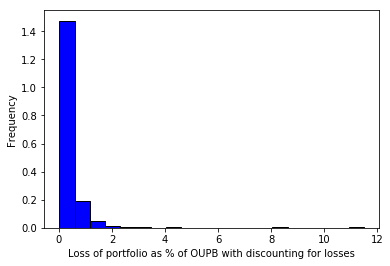

In [76]:
#plt.hist(ave_loss, bins= 20, normed=1, facecolor="blue", edgecolor='black')
#plt.ylabel('Frequency')
#plt.xlabel("Loss of portfolio as % of OUPB with discounting for losses")
#plt.show()

In [ ]:

ave_loss

In [14]:
result_dt = pd.DataFrame(ave_loss)

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

C:\Users\DELL\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


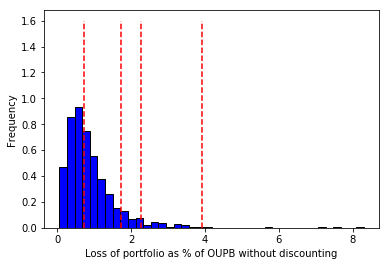

In [16]:
#Knowing the 50th percentile losses
result_dt.describe()
# EL simulation diagram simulation
#result_dt = pd.DataFrame(ave_loss)
plt.hist(ave_loss, bins= 40, normed=1, facecolor="blue", edgecolor='black')
#plt.hist(ave_dt, bins= 20, normed=1, facecolor="blue", edgecolor='black')
plt.vlines(result_dt.quantile(0.5), 0, 1.6, color = 'red', linestyles = 'dashed')
plt.vlines(result_dt.quantile(0.9), 0, 1.6, color = 'red', linestyles = 'dashed')
plt.vlines(result_dt.quantile(0.95), 0, 1.6, color = 'red', linestyles = 'dashed')
plt.vlines(result_dt.quantile(0.99), 0, 1.6, color = 'red', linestyles = 'dashed')
#np.array(ave_dt).mean()
plt.ylabel('Frequency')
plt.xlabel("Loss of portfolio as % of OUPB without discounting")
plt.show()

C:\Users\DELL\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


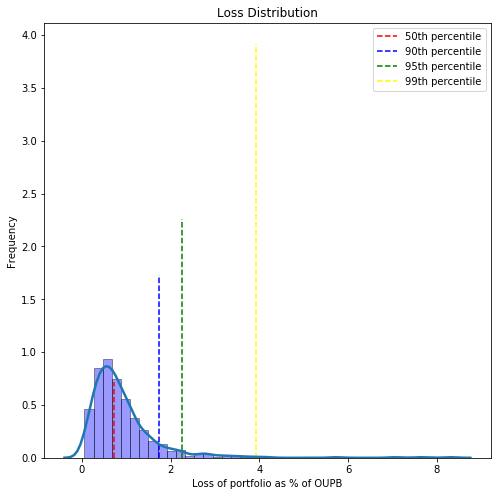

In [17]:
figure(figsize=(8,8))
sns.distplot(ave_loss,hist=True, kde=True, bins=40,hist_kws={'facecolor':'blue','edgecolor':'black'},kde_kws={'linewidth':2.5})
plt.vlines(result_dt.quantile(0.5), 0, 0.72, color = 'red', linestyles = 'dashed', label='50th percentile')
plt.vlines(result_dt.quantile(0.9), 0, 1.73, color = 'blue', linestyles = 'dashed', label='90th percentile')
plt.vlines(result_dt.quantile(0.95), 0, 2.26, color = 'green', linestyles = 'dashed', label='95th percentile')
plt.vlines(result_dt.quantile(0.99), 0, 3.92, color = 'yellow', linestyles = 'dashed', label='99th percentile')
plt.ylabel('Frequency')
plt.xlabel("Loss of portfolio as % of OUPB")
plt.title("Loss Distribution")

plt.legend()
#plt.show()


In [18]:
# Knowing the 99th percentile losses
print(result_dt.quantile(0.50))
print(result_dt.quantile(0.90))
print(result_dt.quantile(0.95))
print(result_dt.quantile(0.99))
#result_dt.quantile(0.99)

0    0.728806
Name: 0.5, dtype: float64
0    1.732701
Name: 0.9, dtype: float64
0    2.261227
Name: 0.95, dtype: float64
0    3.919223
Name: 0.99, dtype: float64


In [19]:
result_dt = result_dt.sort_values(by=0)

In [39]:
result_dt

,0
105,0.020213
259,0.050269
347,0.053018
255,0.065651
328,0.066459
95,0.067622
11,0.069698
92,0.069724
316,0.074899
281,0.075797


In [20]:
#Valuation code for last week starts here
# Tranch Valuation by calculating the losses and payoffs for each of the loss scenarios
d1=100-3.92
d2=3.92-2.26
d3=2.26-1.73
d4=1.73-0.73
d5=0.73-0.00000000000000000000000000000000000000000000000000000001
loss_subordination=[0,0.73,1.73,2.26,3.92]
CDO_percentage=[d5,d4,d3,d2,d1]
referencepoolsize=sumUPB
tranchsize=[]
for i in CDO_percentage:
    tranchsize.append((referencepoolsize*i)/100)

In [58]:
tranchsize

[18288419.9, 25052630.0, 13277893.899999995, 41587365.800000004, 2407056690.4]

In [30]:
Tranche = pd.DataFrame()
Tranche['Loss Subordination'] = loss_subordination
Tranche['CDO %'] = CDO_percentage
Tranche['Tranche size'] = tranchsize
Tranche


,Loss Subordination,CDO %,Tranche size
0,0.00,0.73,1.828842e+07
1,0.73,1.00,2.505263e+07
2,1.73,0.53,1.327789e+07
3,2.26,1.66,4.158737e+07
4,3.92,96.08,2.407057e+09


In [43]:

#len(Tranche['Tranche size'])
result_dt

,0
397,0.057054
111,0.065834
207,0.069989
129,0.075891
176,0.079407
475,0.084158
288,0.091297
154,0.092870
233,0.101333
430,0.117142


In [31]:
Tranch_Loss =[]*500
Tranch_Loss1=[]*500
Tranch_Loss2=[]*500
Tranch_Loss3=[]*500
Tranch_Loss4=[]*500
Tranch_Payoff = []
losses = [0]*500
payoff = [0]*500 
losses1 = [0]*500
payoff1 = [0]*500 
losses2=[0]*500
payoff2 = [0]*500 
losses3=[0]*500
payoff3 = [0]*500 
losses4=[0]*500
payoff4 = [0]*500 
#quarterly_rate = (((1.0254**(1/4))-1)*4)
for i in range(0,len(Tranche['Tranche size'])):
    
    payoffs =[]
    j=-1
    
    for el in result_dt[0]:
        j=j+1
        if(i==0):
            x = (min(Tranche['Tranche size'][i],(el*sumUPB/100)))
            losses[j]=x
            payoff[j]=Tranche['Tranche size'][i]-x
        elif(i==1):
            #print("hello")
            x=min(Tranche['Tranche size'][i],((el*sumUPB/100)-losses[j]))
            losses1[j]=x
            payoff1[j]=Tranche['Tranche size'][i]-x
            #print(x)
            #print(losses1[j])
        elif(i==2):
            x=min(Tranche['Tranche size'][i],((el*sumUPB/100)-losses[j]-losses1[j]))
            payoff2[j]=Tranche['Tranche size'][i]-x
            losses2[j]=x
        elif(i==3):
            x=min(Tranche['Tranche size'][i],((el*sumUPB/100)-losses[j]-losses1[j]-losses2[j]))
            payoff3[j]=Tranche['Tranche size'][i]-x
            losses3[j]=x
        else:
            x=min(Tranche['Tranche size'][i],((el*sumUPB/100)-losses[j]-losses1[j]-losses2[j]-losses3[j]))
            payoff4[j]=Tranche['Tranche size'][i]-x
            losses4[j]=x
        
        #payoffs.append(Tranche['Tranche size'][i]-x)
    
    if(i==0):
        Tranch_Loss.append(losses)
    elif(i==1):    
        Tranch_Loss1.append(losses1)
    elif(i==2):    
        Tranch_Loss2.append(losses2)
    elif(i==3):    
        Tranch_Loss3.append(losses3)
    else:
        Tranch_Loss4.append(losses4)
    
    #Tranch_Loss.append(losses)
    #Tranch_Payoff.append(payoffs)
    

In [32]:
Price1=0
Price2=0
Price3=0
Price4=0
Price5=0

In [46]:
payoff[500]

IndexError: list index out of range

In [33]:
payoff=[i*0.002 for i in payoff]

In [34]:
payoff1=[i*0.002 for i in payoff1]
payoff2=[i*0.002 for i in payoff2]
payoff3=[i*0.002 for i in payoff3]
payoff4=[i*0.002 for i in payoff4]

In [35]:

for i in range(0,len(Tranche['Tranche size'])):
    for k in range(0,500):
        if(i==0):
            #print(payoff[1])
            #print(k)
            Price1=Price1+payoff[k]
            #print((1/500)*payoff[k])
        if(i==1):
            Price2=Price2+payoff1[k]
        if(i==2):
            Price3=Price3+payoff2[k]
        if(i==3):
            Price4=Price4+payoff3[k]
        if(i==4):
            Price5=Price5+payoff4[k]    
        
        
    
    
    

In [36]:
Price1

3617531.512830663

In [37]:
import math
a=0.0254

In [38]:
# Discounting the prices at moody's baseline 1 year rate
PriceofTranche1=Price1*math.exp(-a)
PriceofTranche2=Price2*math.exp(-a)
PriceofTranche3=Price3*math.exp(-a)
PriceofTranche4=Price4*math.exp(-a)
PriceofTranche5=Price5*math.exp(-a)

# Calculating the yield of B/BB and BBB/A rated tranche
Y1 = math.log(Tranche['Tranche size'][0]/PriceofTranche1)*100
Y2 = math.log(Tranche['Tranche size'][1]/PriceofTranche2)*100
Y3 = math.log(Tranche['Tranche size'][2]/PriceofTranche3)*100
Y4 = math.log(Tranche['Tranche size'][3]/PriceofTranche4)*100
Y5 = math.log(Tranche['Tranche size'][4]/PriceofTranche5)*100


Y = [Y1,Y2,Y3,Y4,Y5]
Prices = [PriceofTranche1,PriceofTranche2,PriceofTranche3,PriceofTranche4,PriceofTranche5]
Pricing = ['Tranche 1 no rating','Tranche 2 has no rating','B/BB','BBB/A','Tranche 5 has no rating']

Ratings = pd.DataFrame()
Ratings['Pricing'] = Pricing
Ratings['Prices'] = Prices
Ratings['Yield'] = Y

Ratings.set_index('Pricing')
Ratings.head()

,Pricing,Prices,Yield
0,Tranche 1 no rating,3.526803e+06,164.587618
1,Tranche 2 has no rating,1.858195e+07,29.878820
2,B/BB,1.198814e+07,10.218252
3,BBB/A,3.947484e+07,5.213302
4,Tranche 5 has no rating,2.346039e+09,2.567638


In [39]:
PriceofTranche1

3526803.3380214963